# Classifier Performance Analysis

This notebook evaluates the performance of a model trained using 'xyz_training_model.ipynb'.

The training notebook contains some performance analysis, particularly comparing the training and validation loss as well as outputting the final loss and accuracy on the test set. Here we focus and expand upon the final test performance.

A few markdown/plaintext sections contain explanations and interpretations of outputs that are written with our original saved model in mind. These are denoted by the following line (just an example in this case)...

#### [Original Model/Data Only]

...The content of these sections will not match the results and statistics produced by a different model or when using different test data. This notebook can still be used in these cases, but the textual elements in question should be ignored. Some variable names may also reflect this original purpose (e.g. 'qm9_03_test').

This notebook makes use of code from our various other notebooks and scripts. Documentation and disclaimers such as references to use of AI are included where applicable.

### Imports

All imports are grouped here for clarity

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.config import enable_unsafe_deserialization
from keras.saving import register_keras_serializable

from sklearn import metrics

from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda
from tensorflow.keras.activations import relu
from tensorflow.keras.initializers import RandomUniform

2025-05-22 13:41:31.415270: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 13:41:31.416109: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 13:41:31.418527: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 13:41:31.426370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747885291.437730   19210 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747885291.44

### Datasets

Here we load the test data from the provided file path(s). Be sure to update said paths to match the location of your data if necessary.

#### [Original Model/Data Only]

This notebook uses the test data from the same datasets as the training notebook (by default). These sets are comprised of a mix of in-equilibrium molecules taken directly from the QM9 database and some artificial out-of-equilibrium molecules. The latter were created by randomly displacing some of the atoms for other samples from the QM9 database.

The two datasets were created using different levels of displacement.

1. Molecules in the primary dataset have a total displacement of 0.3 angrstroms across the atoms coordinates.
2. Molecules in the secondary dataset have a total displacement of 0.5 angstroms across the atoms coordinates.

In [5]:
# --- GOOGLE DRIVE --- #
# If you are running this in Google Colab, using your Google Drive for the dataset, run
# this cell (or uncomment the following lines and comment out those in the next cell)
#from google.colab import drive

#drive.mount('/content/drive')

# Then in the next cell, set the path to your directories in Google Drive.
# e.g.
#qm9_03_test = '/content/drive/MyDrive/qm9_03_test'
#qm9_05_test = '/content/drive/MyDrive/qm9_05_test'

In [6]:
# --- LOCAL FILES --- #

# Displaced by 0.3 angrstroms
qm9_03_test = "qm9_03/qm9_03_test"

# Displaced by 0.5 angrstroms
qm9_05_test = "qm9_05/qm9_05_test"

### Custom Layers

The training notebook defines several custom layers that are used in the model. We need to define those layers here as well in order to make predictions using the model.

In [8]:
def masked_avg_pooling(x, mask):
    mask = tf.expand_dims(mask, axis=-1) # -> (batch_size, num_nodes, 1)
    x_masked = x * mask # zero out masked nodes
    sum_x = tf.reduce_sum(x_masked, axis=1) # (batch_size, feature_dim)
    sum_mask = tf.reduce_sum(mask, axis=1) + 1e-7 # prevent division by zero
    return sum_x / sum_mask # (batch_size, feature_dim)

@register_keras_serializable()
class GCNNLayer(layers.Layer):
    # Constructor for the Graph Convolutional Neural Network Layer
    def __init__(self, output_size, **kwargs):
        super().__init__(**kwargs)
        self.output_size = output_size
        # Should be default values
        self.initializer = RandomUniform(minval=-0.05, maxval=0.05, seed=None)

    # Build creates the state of the layer (weights and bias)
    def build(self, input_shape):
        # num_features per node
        num_features = input_shape[0][-1]
        # This is our main weights matrix
        self.kernel = self.add_weight(shape=(num_features, self.output_size),initializer=self.initializer)
        # This is to add a bias to the output
        self.bias = self.add_weight(shape=(self.output_size,),initializer='zeros')
        # Build the layer by calling the parent class and this method
        super().build(input_shape)

    # Called every forward pass for the GraphConvLayer
    def call(self, inputs):
        # Extract the node features and adjacency matrix
        node_features, adjacency = inputs

        # Message passing via adjacency matrix
        # For each node, we multiply the adjacency matrix with the node features
        messages = tf.matmul(adjacency, node_features)

        # Apply the weights and bias then the activation function
        return relu(tf.matmul(messages, self.kernel) + self.bias)

### Load Model

The training notebook exports the trained model as a .keras file. We can load that file in order to make use of the already trained model. The .keras file must be in the same directory, otherwise the file path within the load_model() function should be adjusted accordingly.

In [10]:
# REFERENCE: The block of code below has been generated by ChatGPT
# it has been refactored a little and commented.
# -- BEGIN AI GENERATED CODE -- #
enable_unsafe_deserialization()
model = tf.keras.models.load_model(
    "xyz_model.keras",
    custom_objects={
        'GCNNLayer': GCNNLayer,
        'masked_avg_pooling': masked_avg_pooling
    }
)
# Replace the masked_avg_pooling Lambda with a layer
for layer in model.layers:
    if isinstance(layer, Lambda):
        layer.function = lambda args, fn=masked_avg_pooling: fn(args[0], args[1])
# -- END AI GENERATED CODE -- #

2025-05-22 13:41:32.900629: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Prepare test datasets

In [12]:
# Prepare test sets
batch_size = 32

test_ds = tf.data.Dataset.load(qm9_03_test)
test_ds_05 = tf.data.Dataset.load(qm9_05_test)

test_ds = test_ds.batch(batch_size, drop_remainder=True)
test_ds_05 = test_ds_05.batch(batch_size, drop_remainder=True)

### Performance Evaluation (0.3 Angstroms Displacement)

For each dataset we first have to use the model to make predictions on the set. Then we can compare those predictions to the real class for each molecule and generate performance statistics.

This first block just makes the predictions and prepares the output data for comparison. The 'n_samples' variable on the first line will determine the number of samples used across subsequent predictions and evaluations as well so that they can be compared. A value greater than the number of samples in the other test won't produce an error, but it will mean the statistics for each will be based on different numbers of samples and thus may not allow a meaningful comparison.

When adjusting 'n_samples', remember that the test sets are stored as batches, with each batch containing 'batch_size' samples.

In [14]:
# Evaluate the model using the test data (0.3 angstroms displacement)
n_samples = len(test_ds) * batch_size

# Run predictions on our test dataset
preds = model.predict(test_ds).flatten()

# This is for storing our labels
true = []
rounded = []

# Extract and store each label
for _, y in test_ds.as_numpy_iterator():
    true.extend(y)
true = np.array(true).flatten()

# Iterate through the predictions, round the probability for a label
for i in range(n_samples):
    rounded.append(int(np.round(preds[i])))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


2025-05-22 13:41:33.328751: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


A confusion matrix is a good way of visualising a model's performance on a test set in terms of false positives (top right), true positives (bottom right), false negatives (bottom left) and true negatives (top left). The scikit-learn implementation used here also allows us to easily extract these numbers in the next step.

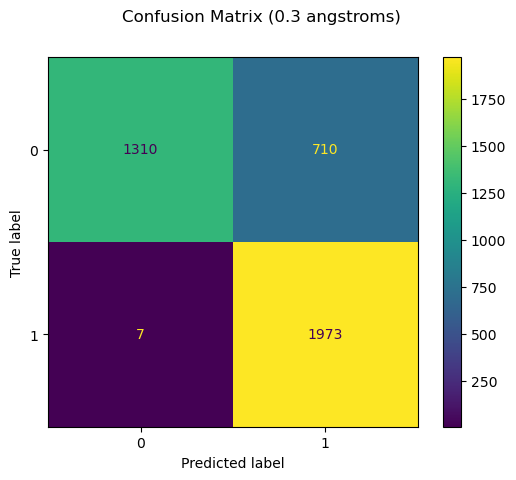

In [16]:
confusion_matrix = metrics.confusion_matrix(true[0:n_samples], rounded)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.suptitle("Confusion Matrix (0.3 angstroms)")
plt.show()

Here we extract the aforementioned statistics from the confusion matrix and use those to calculate other useful statistics. These include:

- Accuracy: A straightforward measure of model performance, simply calculated by dividing the number of correct predictions by the total number of predictions.
  
- Precision: While accuracy gives a sense of overall performance across both classes (in this case in equilibrium and out-of-equilibrium), precision tells you how well the model does when it comes the positive class (in equilibrium) specifically. It tells you what portion of the samples classified as positive are actually positive.


- Negative Predicted Value (NPV): The opposite of precision, this is what portion of the negative classifications are actually negative.

  
- Recall/Sensitivity: Similar to precision in the sense it gives a more specific insight than the overall accuracy, recall tells you what portion of the truly positive samples are identified as such. In a binary case like this it is the same thing as 'sensitivity'.

- Specificity: The opposite of sensitivity, it is the portion of truly negative samples that are predicted to be negative.

- F1-Score: A way of summarising precision and recall. There is typically a tradeoff between these two statistics, and the F1-score is generally better when both can achieve a relatively high value regardless. Unlike the other statistics, this requires something to be compared to, which we will get to later.

In [18]:
# Extract true positive, false positive, false negative and true positive count
tn, fp, fn, tp = confusion_matrix.ravel()

# Calculate total correct, incorrect and accuracy
correct = tp + tn
incorrect = fp + fn
total = correct + incorrect
accuracy = correct/total

# Calculate precision, recall and F1-score
precision = tp / (tp + fp)
npv = tn / (tn + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

# Display statistics
print(f"\n(positive class = in-equilibrium)\n")
print(f"\nCorrectly classified: {correct}/{total}")
print(f"\nAccuracy: {accuracy:.5f}")
print(f"\nPrecision: {precision:.5f}")
print(f"\nNegative Predicted Value: {npv:.5f}")
print(f"\nRecall/Sensitivity: {sensitivity:.5f}")
print(f"\nSpecificity: {specificity:.5f}")
print(f"\nF1-score: {f1:.5f}")
print(f"\n\n -- All statistics rounded to 5 decimal places --")


(positive class = in-equilibrium)


Correctly classified: 3283/4000

Accuracy: 0.82075

Precision: 0.73537

Negative Predicted Value: 0.99468

Recall/Sensitivity: 0.99646

Specificity: 0.64851

F1-score: 0.84624


 -- All statistics rounded to 5 decimal places --


#### [Original Model/Data Only] 

Some interpretations from this performance include:

- About 82% of samples are correctly classified by the model.

- About 74% of samples classified as positive are actually positive. The other quarter or so of them are false positives. About 35% (1 - specificity) of truly negative samples (just under 99.5%) are misclassified as positive.

- Almost all samples (just under 99.5%) classified as negative are actually negative. This corresponds with the fact that almost all truly positive samples are correctly classified (over 99.6%).

Overall, the model is very reliable in terms of making sure positive samples aren't misclassified as negative ones, but in order to achieve this it has to be lenient about what gets treated as a positive sample, to the point where a number of negative samples are misclassified as such.

### Performance Evaluation (0.5 Angstroms  Displacement)

In [21]:
# If using the full 0.3 set, use the full 0.5 as well, even if different lengths
n_samples_05 = 0
if (n_samples == len(test_ds) * batch_size):
    n_samples_05 = len(test_ds_05) * batch_size
# If we're using some custom amount, should be the same amount from both sets
else:
    n_samples_05 = n_samples

# Run predictions on our test dataset
preds_05 = model.predict(test_ds_05).flatten()

# This is for storing our labels
true_05 = []
rounded_05 = []

# Extract and store each label
for _, y in test_ds_05.as_numpy_iterator():
    true_05.extend(y)
true_05 = np.array(true_05).flatten()

# Iterate through the predictions, round the probability for a label
for i in range(n_samples_05):
    rounded_05.append(int(np.round(preds_05[i])))

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


2025-05-22 13:41:33.659618: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


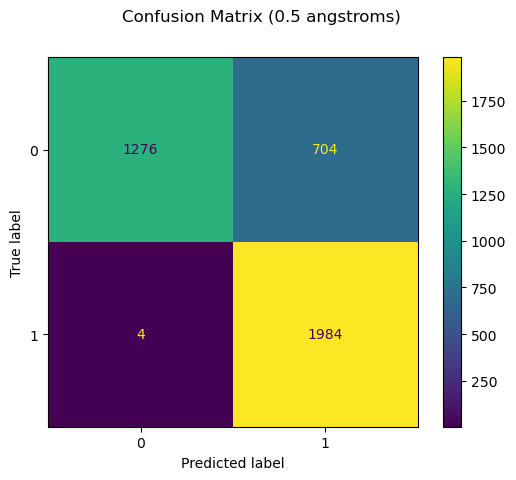

In [22]:
confusion_matrix_05 = metrics.confusion_matrix(true_05[0:n_samples_05], rounded_05)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_05, display_labels = [0, 1])
cm_display.plot()
plt.suptitle("Confusion Matrix (0.5 angstroms)")
plt.show()

In [23]:
# Extract true positive, false positive, false negative and true positive count
tn_05, fp_05, fn_05, tp_05 = confusion_matrix_05.ravel()

# Calculate total correct, incorrect and accuracy
correct_05 = tp_05 + tn_05
incorrect_05 = fp_05 + fn_05
total_05 = correct_05 + incorrect_05
accuracy_05 = correct_05/total_05

# Calculate precision, recall and F1-score
precision_05 = tp_05 / (tp_05 + fp_05)
npv_05 = tn_05 / (tn_05 + fn_05)
sensitivity_05 = tp_05 / (tp_05 + fn_05)
specificity_05 = tn_05 / (tn_05 + fp_05)
f1_05 = 2 * (precision_05 * sensitivity_05) / (precision_05 + sensitivity_05)

# Display statistics
print(f"\n(positive class = in-equilibrium)\n")
print(f"\nCorrectly classified: {correct_05}/{total_05}")
print(f"\nAccuracy: {accuracy_05:.5f}")
print(f"\nPrecision: {precision_05:.5f}")
print(f"\nNegative Predicted Value: {npv_05:.5f}")
print(f"\nRecall/Sensitivity: {sensitivity_05:.5f}")
print(f"\nSpecificity: {specificity_05:.5f}")
print(f"\nF1-score: {f1_05:.5f}")
print(f"\n\n -- All statistics rounded to 5 decimal places --")


(positive class = in-equilibrium)


Correctly classified: 3260/3968

Accuracy: 0.82157

Precision: 0.73810

Negative Predicted Value: 0.99687

Recall/Sensitivity: 0.99799

Specificity: 0.64444

F1-score: 0.84859


 -- All statistics rounded to 5 decimal places --


#### [Original Model/Data Only] 

Some interpretations from this performance include:

- Again, about 82% (actually slightly higher than last time) of samples are correctly classified by the model.

- Again, about 74% (also slightly higher then with the 0.3 set before rounding) of samples classified as positive are actually positive. The rest are false positives. About 36% (1 - specificity) of truly negative samples are misclassified as positive.

- Almost all samples classified as negative are actually negative (almost 99.7%). This corresponds with the fact that almost all (about 99.8%) truly positive samples are correctly classified.

Again, the model is very reliable in terms of making sure positive samples aren't misclassified as negative ones at the cost of having loose standards for positive classification. The tradeoff is slightly less pronounced in this case, however, as evidenced by the improved F1-score. The overall performance is slightly better as well, which isn't surprising as this dataset uses more heavily displaced and thus more obvious out-of-equilibrium molecules, though the fact the difference isn't more dramatic is somewhat surprising.

### Performance Evaluation (Baseline)

In order to contextualise our F1-scores we need a baseline score. Here we generate such a score by calculating the same statistics from predictions made on the 0.3 angstrom displacement test set using a model which always classifies molecules as in equilibrium. This "model" isn't a real model, we just generate a set of "predictions" that are all positive as if they had been produced by such a model. We treat it as if the input to this model was the 0.3 displacement set so we know what to compare it to for the "true" classes (the test set in question).

Statistics based on a rudimentary classifier like this are a useful comparison for things other than the F1-score, so we compute all of the same statistics and display the confusion matrix just as before.

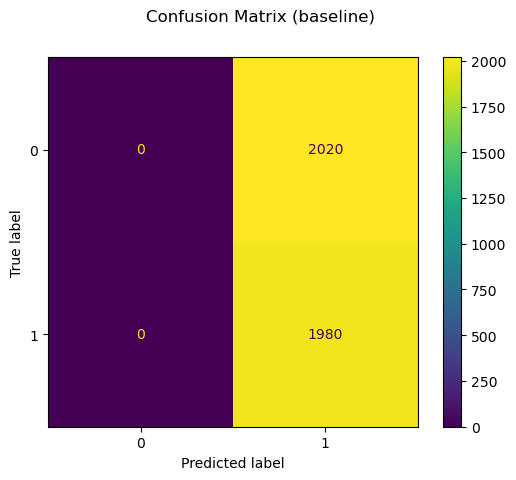


(positive class = in-equilibrium)


Correctly classified: 1980/4000

Accuracy: 0.49500

Precision: 0.49500

Negative Predicted Value: NaN (would be dividing zero by zero)

Recall/Sensitivity: 1.00000

Specificity: 0.00000

F1-score: 0.66221


 -- All statistics rounded to 5 decimal places --


In [26]:
# Create baseline "predictions"
baseline = [1] * n_samples

# Create a confusion matrix for the predictions
base_conf_matrix = metrics.confusion_matrix(true[0:n_samples], baseline)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = base_conf_matrix, display_labels = [0, 1])
cm_display.plot()
plt.suptitle("Confusion Matrix (baseline)")
plt.show()

# Extract true positive, false positive, false negative and true positive count
base_tn, base_fp, base_fn, base_tp = base_conf_matrix.ravel()

# Calculate total correct, incorrect and accuracy
base_correct = base_tp + base_tn
base_incorrect = base_fp + base_fn
base_total = base_correct + base_incorrect
base_accuracy = base_correct/base_total

# Calculate precision, recall and F1-score
base_precision = base_tp / (base_tp + base_fp)
# We don't calculate NPV because there are no true or false negatives in the baseline predictions (0/0+0)
base_sensitivity = base_tp / (base_tp + base_fn)
base_specificity = base_tn / (base_tn + base_fp)
base_f1 = 2 * (base_precision * base_sensitivity) / (base_precision + base_sensitivity)

# Display statistics
print(f"\n(positive class = in-equilibrium)\n")
print(f"\nCorrectly classified: {base_correct}/{base_total}")
print(f"\nAccuracy: {base_accuracy:.5f}")
print(f"\nPrecision: {base_precision:.5f}")
print(f"\nNegative Predicted Value: NaN (would be dividing zero by zero)")
print(f"\nRecall/Sensitivity: {base_sensitivity:.5f}")
print(f"\nSpecificity: {base_specificity:.5f}")
print(f"\nF1-score: {base_f1:.5f}")
print(f"\n\n -- All statistics rounded to 5 decimal places --")

##### [Original Model/Data Only] 

Some interpretations from this baseline performance include:

- Only about 50% of samples are correctly classified by the model.

- Because all samples are classified as positive, this also means roughly 50% of samples classified as positive are actually positive. The rest are false positives. Unsurprisingly, all truly negative samples are misclassified as positive.

- We can't compute the NPV because that would involve dividing by zero. There are no false negatives, but that's because there are no negative classifications at all.

This always positive classifier performs roughly equal to chance, which makes sense as there are close to an equal number of samples belongong to each class in the test set. It does manage to achieve a sensitivity of 1, meaning no positive samples are misclassified, but we can achieve something very close to this with our actual model while maintaining significantly better performance in other areas.

Of course, the main use for the baseline is as a point of comparison for the previous F1-scores. Both the 0.3 and 0.5 displacement test sets achieved a score of just under 0.85, compared to around 0.66 in this case. That means our model significantly improves over this basic strategy in terms of precision and recall, so we can consider the scores for the two tests sets to be good.

### Performance Summaries

These last few blocks give an additional statistic, the model's loss (always based on the full test set), and summarise/compare model performance across the two test sets (and in some cases the baseline) for ease of interpretability.

In [29]:
loss, _ = model.evaluate(test_ds)
loss_05, _ = model.evaluate(test_ds_05)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.8134 - loss: 0.1082
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.8218 - loss: 0.1061


In [30]:
print(f"\n __ Loss Summary __")
print(f"\nLoss with 0.3 angstroms: {loss:.5f}")
print(f"\nLoss with 0.5 angstroms: {loss_05:.5f}")
print(f"\n\n -- All statistics rounded to 5 decimal places --")


 __ Loss Summary __

Loss with 0.3 angstroms: 0.10782

Loss with 0.5 angstroms: 0.10710


 -- All statistics rounded to 5 decimal places --


In [31]:
print(f"\n __ Accuracy Summary __")
print(f"\nBaseline classification: {base_correct}/{base_total}")
print(f"\nClassification with 0.3 angstroms: {correct}/{total}")
print(f"\nClassification with 0.5 angstroms: {correct_05}/{total_05}")


 __ Accuracy Summary __

Baseline classification: 1980/4000

Classification with 0.3 angstroms: 3283/4000

Classification with 0.5 angstroms: 3260/3968


In [32]:
print(f"\n __ F1-Score Summary __")
print(f"\nBaseline F1-score: {base_f1:.5f}")
print(f"\nF1-score with 0.3 angstroms: {f1:.5f}")
print(f"\nF1-score with 0.5 angstroms: {f1_05:.5f}")
print(f"\n\n -- All statistics rounded to 5 decimal places --")


 __ F1-Score Summary __

Baseline F1-score: 0.66221

F1-score with 0.3 angstroms: 0.84624

F1-score with 0.5 angstroms: 0.84859


 -- All statistics rounded to 5 decimal places --
